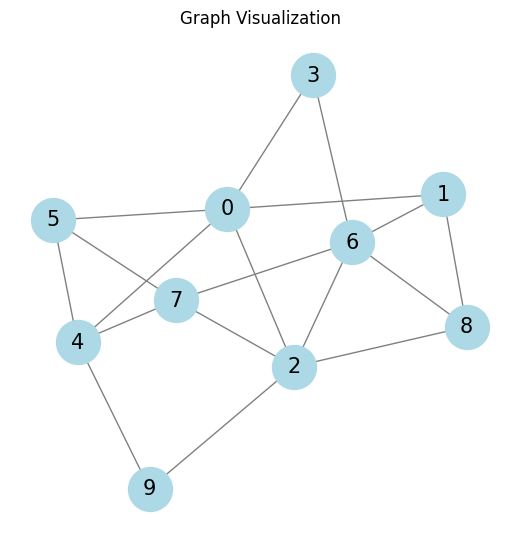

Valid Solutions:
[0, 1, 2, 4, 5, 6, 8]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[2, 3, 4, 5, 6, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 6, 7]
[0, 1, 2, 4, 5, 6, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 2, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 4, 6, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 6, 7]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2

In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
import pennylane as qml
import matplotlib.pyplot as plt

# Function to visualize the graph
def plot_graph(G):
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1000, font_size=15)
    plt.title("Graph Visualization")
    plt.show()

# Step 1: Generate a random graph
np.random.seed(42)  
num_vertices = 10 # Fixed number of vertices
G = nx.erdos_renyi_graph(num_vertices, 0.5)  # Random graph 
plot_graph(G)

# Step 2: Define QUBO for 2-Domination Problem
def qubo_2_domination(G, P1=100, P2=100):
    n = len(G.nodes)
    slack_bits = int(np.ceil(np.log2(n - 1)))
    Q_size = n + slack_bits
    Q = np.zeros((Q_size, Q_size))

    # Objective function for 2-domination
    for i in range(n):
        Q[i, i] += 1
    #Constraint to include atleast 2 neighbours
    for i in range(n):
        neighbors = list(G.neighbors(i))
        constraint_expr = -2  

        for j in neighbors:
            Q[i, j] -= P1 / 2
            Q[j, j] += P1 / 4
            Q[i, i] += P1 / 4
            constraint_expr += 1
        
        # Implement slack variable representation
        slack_sum = 0
        for k in range(slack_bits - 1):  
            slack_idx = n + k
            slack_sum += (2 ** k) * Q[slack_idx, slack_idx]
            Q[i, slack_idx] -= P1 * (2 ** k)
        
        last_slack_idx = n + slack_bits - 1
        last_coeff = (n - 1) - (2 ** (slack_bits - 1) - 1)
        Q[last_slack_idx, last_slack_idx] += P1 * last_coeff
        Q[i, last_slack_idx] -= P1 * last_coeff
    
    # Constraint for nodes with degree < 2
    for i in range(n):
        if G.degree[i] < 2:
            Q[i, i] += P2 * (1 - 2 * 1 + 1 ** 2)
    
    return Q

Q = qubo_2_domination(G)

# Convert QUBO to Hamiltonian Form using Pauli-Z operators
def qubo_to_hamiltonian(Q):
    n = len(Q)
    coeffs = []
    ops = []

    for i in range(n):
        coeffs.append(-Q[i, i] / 2)
        ops.append(qml.PauliZ(i))

        for j in range(i + 1, n):
            if Q[i, j] != 0:
                coeffs.append(Q[i, j] / 4)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)

hamiltonian = qubo_to_hamiltonian(Q)

# Define Quantum Device
num_qubits = num_vertices + int(np.ceil(np.log2(num_vertices - 1)))
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

#QAOA Circuit using the Hamiltonian
@qml.qnode(dev)
def qaoa_circuit(gammas, betas, hamiltonian, num_qubits):
    p = len(gammas)  # Number of QAOA layers

    # Step 1: Initialize in |s⟩ using Hadamard gates
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    
    # Step 2: Apply QAOA alternating unitary layers
    for layer in range(p):
        # Apply Cost Hamiltonian Unitary U(C, γ)
        qml.ApproxTimeEvolution(hamiltonian, gammas[layer], 1)

        # Apply Mixing Unitary U(B, β)
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)

    return qml.sample()

# Run QAOA
gammas, betas = [0.5] * 3, [0.3] * 3  # Initial parameters
samples = qaoa_circuit(gammas, betas, hamiltonian, num_qubits=num_qubits)

# Step 4: Validate Solutions
def valid_solution(sample, G):
    included = [i for i in range(num_vertices) if sample[i] == 1]
    for i in range(num_vertices):
        if i not in included:
            neighbors_included = sum(1 for j in G.neighbors(i) if j in included)
            if neighbors_included < 2:
                return False
    return included

print("Valid Solutions:")
valid_solutions = [valid_solution(sample, G) for sample in samples if valid_solution(sample, G)]
for i in valid_solutions:
    print(i)
print(f"Valid solutions found: {len(valid_solutions)} / {len(samples)}")

# Find Optimal Solution
def find_optimal_solution(valid_solutions):
    if valid_solutions:
        optimal_solution = min(valid_solutions, key=len)
        print("Optimal Solution (Minimum Vertex Set):", optimal_solution)
        print("Size of Optimal Solution:", len(optimal_solution))
    else:
        print("No valid solutions found.")

find_optimal_solution(valid_solutions)


In [2]:
print(qml.version())

0.40.0


In [4]:
import numpy as np
import networkx as nx
from collections import defaultdict
import pennylane as qml
import matplotlib.pyplot as plt
import time

# Function to visualize the graph with solution highlighted
def plot_graph(G, solution=None, graph_name=""):
    plt.figure(figsize=(6, 6))
    
    # Choose appropriate layout based on graph type
    if "path" in graph_name.lower():
        pos = nx.kamada_kawai_layout(G)
    elif "cycle" in graph_name.lower():
        pos = nx.circular_layout(G)
    elif "star" in graph_name.lower():
        pos = nx.kamada_kawai_layout(G)
    elif "petersen" in graph_name.lower():
        pos = nx.spring_layout(G, seed=42)
    else:
        pos = nx.spring_layout(G, seed=42)
    
    # Different colors for solution nodes and regular nodes
    if solution:
        node_colors = ['red' if i in solution else 'lightblue' for i in G.nodes]
        nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', 
                node_size=800, font_size=12, font_weight='bold')
        plt.title(f"{graph_name} with 2-Domination Solution (Size: {len(solution)})")
    else:
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', 
                node_size=800, font_size=12)
        plt.title(f"{graph_name}")
    
    plt.tight_layout()
    return plt

# Generate specific graph types
def generate_specific_graph(graph_type):
    if graph_type == "path_3":
        G = nx.path_graph(3)
        name = "3-Vertex Path Graph"
    elif graph_type == "cycle_4":
        G = nx.cycle_graph(4)
        name = "4-Vertex Cycle Graph"
    elif graph_type == "star_6":
        G = nx.star_graph(5)  # 5 outer vertices + 1 center = 6 vertices
        name = "6-Vertex Star Graph"
    elif graph_type == "petersen":
        G = nx.petersen_graph()
        name = "10-Vertex Petersen Graph"
    else:
        raise ValueError(f"Unknown graph type: {graph_type}")
    
    return G, name

# Define QUBO for 2-Domination Problem
def qubo_2_domination(G, P1=100, P2=100):
    start_time = time.time()
    
    n = len(G.nodes)
    slack_bits = int(np.ceil(np.log2(n - 1)))
    Q_size = n + slack_bits
    Q = np.zeros((Q_size, Q_size))

    # Objective function for 2-domination (minimize number of vertices)
    for i in range(n):
        Q[i, i] += 1
        
    # Constraint to include at least 2 neighbors
    for i in range(n):
        neighbors = list(G.neighbors(i))
        constraint_expr = -2  

        for j in neighbors:
            Q[i, j] -= P1 / 2
            Q[j, j] += P1 / 4
            Q[i, i] += P1 / 4
            constraint_expr += 1
        
        # Implement slack variable representation
        slack_sum = 0
        for k in range(slack_bits - 1):  
            slack_idx = n + k
            slack_sum += (2 ** k) * Q[slack_idx, slack_idx]
            Q[i, slack_idx] -= P1 * (2 ** k)
        
        last_slack_idx = n + slack_bits - 1
        last_coeff = (n - 1) - (2 ** (slack_bits - 1) - 1)
        Q[last_slack_idx, last_slack_idx] += P1 * last_coeff
        Q[i, last_slack_idx] -= P1 * last_coeff
    
    # Constraint for nodes with degree < 2
    for i in range(n):
        if G.degree[i] < 2:
            Q[i, i] += P2 * (1 - 2 * 1 + 1 ** 2)
    
    end_time = time.time()
    qubo_time = end_time - start_time
    
    return Q, qubo_time

# Convert QUBO to Hamiltonian Form using Pauli-Z operators
def qubo_to_hamiltonian(Q):
    n = len(Q)
    coeffs = []
    ops = []

    for i in range(n):
        coeffs.append(-Q[i, i] / 2)
        ops.append(qml.PauliZ(i))

        for j in range(i + 1, n):
            if Q[i, j] != 0:
                coeffs.append(Q[i, j] / 4)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)

# Modified QAOA Circuit using the Hamiltonian
def create_qaoa_circuit(num_qubits, hamiltonian):
    dev = qml.device("default.qubit", wires=num_qubits, shots=1000)
    
    @qml.qnode(dev)
    def qaoa_circuit(gammas, betas):
        p = len(gammas)  # Number of QAOA layers

        # Step 1: Initialize in |s⟩ using Hadamard gates
        for i in range(num_qubits):
            qml.Hadamard(wires=i)
        
        # Step 2: Apply QAOA alternating unitary layers
        for layer in range(p):
            # Apply Cost Hamiltonian Unitary U(C, γ)
            qml.ApproxTimeEvolution(hamiltonian, gammas[layer], 1)

            # Apply Mixing Unitary U(B, β)
            for i in range(num_qubits):
                qml.RX(-2 * betas[layer], wires=i)

        return qml.sample()
    
    return qaoa_circuit

# Validate if a solution meets the 2-domination criteria
def valid_solution(sample, G, num_vertices):
    included = [i for i in range(num_vertices) if sample[i] == 1]
    for i in range(num_vertices):
        if i not in included:
            neighbors_included = sum(1 for j in G.neighbors(i) if j in included)
            if neighbors_included < 2:
                return False
    return included

# Find the optimal solution from valid solutions
def find_optimal_solution(valid_solutions):
    if valid_solutions:
        return min(valid_solutions, key=len)
    return None

# Main function to solve the 2-domination problem for specific graph types
def solve_2_domination_for_specific_graphs(num_layers=3):
    graph_types = ["path_3", "cycle_4", "star_6", "petersen"]
    execution_times = {'graph_type': [], 'num_vertices': [], 'qubo_time': [], 'qaoa_time': []}
    solution_quality = {}
    
    for graph_type in graph_types:
        G, graph_name = generate_specific_graph(graph_type)
        n_vertices = G.number_of_nodes()
        
        print(f"\n=== Processing {graph_name} ===")
        
        # Plot original graph
        plt_original = plot_graph(G, graph_name=graph_name)
        plt_original.savefig(f"original_{graph_type}.png")
        plt_original.close()
        
        # Calculate QUBO matrix
        Q, qubo_time = qubo_2_domination(G)
        print(f"QUBO matrix calculation time: {qubo_time:.4f} seconds")
        
        # Convert to Hamiltonian
        hamiltonian = qubo_to_hamiltonian(Q)
        
        # Calculate number of qubits needed
        num_qubits = n_vertices + int(np.ceil(np.log2(n_vertices - 1)))
        
        # Create and run QAOA circuit
        qaoa_circuit = create_qaoa_circuit(num_qubits, hamiltonian)
        
        # Initial parameters for QAOA (can be optimized further)
        gammas, betas = [0.5] * num_layers, [0.3] * num_layers
        
        # Execute QAOA
        qaoa_start = time.time()
        samples = qaoa_circuit(gammas, betas)
        qaoa_time = time.time() - qaoa_start
        print(f"QAOA execution time: {qaoa_time:.4f} seconds")
        
        # Validate solutions
        valid_solutions = [valid_solution(sample, G, n_vertices) for sample in samples]
        valid_solutions = [sol for sol in valid_solutions if sol]  # Filter out None values
        
        # Find optimal solution
        optimal_solution = find_optimal_solution(valid_solutions)
        
        if optimal_solution:
            print(f"Optimal 2-dominating set found: {optimal_solution}")
            print(f"Size of optimal solution: {len(optimal_solution)}")
            
            # Compute solution frequency
            solution_sizes = [len(sol) for sol in valid_solutions]
            solution_quality[graph_type] = solution_sizes
            
            # Plot the graph with solution
            plt_graph = plot_graph(G, optimal_solution, graph_name)
            plt_graph.savefig(f"graph_solution_{graph_type}.png")
            plt_graph.close()
            
            # Plot solution distribution
            plt.figure(figsize=(8, 5))
            plt.hist(solution_sizes, bins=range(1, n_vertices+2), alpha=0.7, color='skyblue', edgecolor='black')
            plt.axvline(x=len(optimal_solution), color='red', linestyle='dashed', linewidth=2, label=f'Optimal size: {len(optimal_solution)}')
            
            plt.xlabel('Size of 2-dominating set')
            plt.ylabel('Frequency')
            plt.title(f'Distribution of 2-dominating set sizes for {graph_name}')
            plt.grid(alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"solution_distribution_{graph_type}.png")
            plt.close()
        else:
            print("No valid solution found for this graph")
        
        # Store execution times
        execution_times['graph_type'].append(graph_type)
        execution_times['num_vertices'].append(n_vertices)
        execution_times['qubo_time'].append(qubo_time)
        execution_times['qaoa_time'].append(qaoa_time)
    
    # Plot execution time comparison
    plt.figure(figsize=(12, 7))
    
    # Bar chart for execution times
    x = np.arange(len(execution_times['graph_type']))
    width = 0.35
    
    plt.bar(x - width/2, execution_times['qubo_time'], width, label='QUBO Formulation')
    plt.bar(x + width/2, execution_times['qaoa_time'], width, label='QAOA Execution')
    
    plt.xlabel('Graph Type')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time Comparison for Different Graph Types')
    plt.xticks(x, [f"{gt}\n({nv} vertices)" for gt, nv in zip(execution_times['graph_type'], execution_times['num_vertices'])])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("execution_times_comparison.png")
    plt.close()
    
    # Plot execution time vs. number of vertices
    plt.figure(figsize=(10, 6))
    plt.scatter(execution_times['num_vertices'], execution_times['qubo_time'], marker='o', label='QUBO Time')
    plt.scatter(execution_times['num_vertices'], execution_times['qaoa_time'], marker='s', label='QAOA Time')
    plt.scatter(execution_times['num_vertices'], [q+p for q, p in zip(execution_times['qubo_time'], execution_times['qaoa_time'])], 
               marker='^', label='Total Time')
    
    # Add trend lines
    z1 = np.polyfit(execution_times['num_vertices'], execution_times['qubo_time'], 2)
    z2 = np.polyfit(execution_times['num_vertices'], execution_times['qaoa_time'], 2)
    z3 = np.polyfit(execution_times['num_vertices'], 
                    [q+p for q, p in zip(execution_times['qubo_time'], execution_times['qaoa_time'])], 2)
    
    xp = np.linspace(min(execution_times['num_vertices']), max(execution_times['num_vertices']), 100)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)
    
    plt.plot(xp, p1(xp), '--', alpha=0.7)
    plt.plot(xp, p2(xp), '--', alpha=0.7)
    plt.plot(xp, p3(xp), '--', alpha=0.7)
    
    plt.xlabel('Number of Vertices')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time vs. Graph Size')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("execution_times_vs_vertices.png")
    plt.close()
    
    return execution_times, solution_quality

# Execute the main function
if __name__ == "__main__":
    # Solve for specific graph types
    execution_times, solution_quality = solve_2_domination_for_specific_graphs()
    
    # Print summary of execution times
    print("\n=== Execution Time Summary ===")
    for i, gt in enumerate(execution_times['graph_type']):
        graph_name = ""
        if gt == "path_3": graph_name = "3-Vertex Path Graph"
        elif gt == "cycle_4": graph_name = "4-Vertex Cycle Graph"
        elif gt == "star_6": graph_name = "6-Vertex Star Graph" 
        elif gt == "petersen": graph_name = "10-Vertex Petersen Graph"
        
        print(f"{graph_name}: QUBO Time: {execution_times['qubo_time'][i]:.4f}s, QAOA Time: {execution_times['qaoa_time'][i]:.4f}s, Total: {execution_times['qubo_time'][i] + execution_times['qaoa_time'][i]:.4f}s")


=== Processing 3-Vertex Path Graph ===
QUBO matrix calculation time: 0.0000 seconds
QAOA execution time: 0.0080 seconds
Optimal 2-dominating set found: [0, 2]
Size of optimal solution: 2


C:\Users\Siddhartha Nath\AppData\Local\Temp\ipykernel_4628\3841373651.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



=== Processing 4-Vertex Cycle Graph ===
QUBO matrix calculation time: 0.0000 seconds
QAOA execution time: 0.0146 seconds
Optimal 2-dominating set found: [0, 2]
Size of optimal solution: 2

=== Processing 6-Vertex Star Graph ===
QUBO matrix calculation time: 0.0000 seconds
QAOA execution time: 0.0240 seconds
Optimal 2-dominating set found: [0, 1, 2, 3, 4, 5]
Size of optimal solution: 6

=== Processing 10-Vertex Petersen Graph ===
QUBO matrix calculation time: 0.0000 seconds
QAOA execution time: 0.1079 seconds
Optimal 2-dominating set found: [0, 3, 6, 7]
Size of optimal solution: 4

=== Execution Time Summary ===
3-Vertex Path Graph: QUBO Time: 0.0000s, QAOA Time: 0.0080s, Total: 0.0080s
4-Vertex Cycle Graph: QUBO Time: 0.0000s, QAOA Time: 0.0146s, Total: 0.0146s
6-Vertex Star Graph: QUBO Time: 0.0000s, QAOA Time: 0.0240s, Total: 0.0240s
10-Vertex Petersen Graph: QUBO Time: 0.0000s, QAOA Time: 0.1079s, Total: 0.1079s


In [5]:
def extract_solution_distribution_values(solution_quality):
    """
    Extracts and displays the frequency values from solution distribution histograms
    for already generated graphs.
    
    Parameters:
    solution_quality (dict): Dictionary containing solution sizes for each graph type
    
    Returns:
    dict: Dictionary with detailed distribution statistics for each graph type
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import Counter
    
    # Dictionary to store distribution values
    distribution_values = {}
    
    # Graph type names for better readability
    graph_type_names = {
        "path_3": "3-Vertex Path Graph",
        "cycle_4": "4-Vertex Cycle Graph",
        "star_6": "6-Vertex Star Graph",
        "petersen": "10-Vertex Petersen Graph"
    }
    
    # Process each graph type
    for graph_type, solution_sizes in solution_quality.items():
        if not solution_sizes:
            print(f"No solution data available for {graph_type_names.get(graph_type, graph_type)}")
            continue
            
        # Count occurrences of each solution size
        size_counts = Counter(solution_sizes)
        
        # Get total number of solutions
        total_solutions = len(solution_sizes)
        
        # Calculate statistics
        min_size = min(solution_sizes)
        max_size = max(solution_sizes)
        mean_size = np.mean(solution_sizes)
        median_size = np.median(solution_sizes)
        
        # Store distribution values
        distribution_values[graph_type] = {
            "counts": dict(size_counts),
            "total_solutions": total_solutions,
            "min_size": min_size,
            "max_size": max_size,
            "mean_size": mean_size,
            "median_size": median_size
        }
        
        # Print detailed distribution information
        print(f"\n=== Solution Distribution for {graph_type_names.get(graph_type, graph_type)} ===")
        print(f"Total valid solutions: {total_solutions}")
        print(f"Size range: {min_size} to {max_size} vertices")
        print(f"Average solution size: {mean_size:.2f}")
        print(f"Median solution size: {median_size}")
        print("\nDetailed distribution:")
        
        # Sort by solution size for readability
        for size in sorted(size_counts.keys()):
            count = size_counts[size]
            percentage = (count / total_solutions) * 100
            print(f"  {size} vertices: {count} solutions ({percentage:.1f}%)")
        
        # Create a cleaner bar chart of the distribution
        plt.figure(figsize=(10, 6))
        
        # Get sorted sizes and their counts
        sizes = sorted(size_counts.keys())
        counts = [size_counts[size] for size in sizes]
        
        # Create bar chart
        bars = plt.bar(sizes, counts, color='skyblue', edgecolor='black', alpha=0.7)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', fontsize=10)
        
        # Add red marker for optimal solution (minimum size)
        plt.axvline(x=min_size, color='red', linestyle='dashed', linewidth=2, 
                    label=f'Optimal size: {min_size}')
        
        plt.xlabel('Size of 2-dominating set')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of 2-dominating set sizes for {graph_type_names.get(graph_type, graph_type)}')
        plt.xticks(range(min(sizes), max(sizes) + 1))
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"distribution_values_{graph_type}.png")
        plt.close()
    
    return distribution_values

# Example usage (can be run in a separate cell after the main code):
# distribution_values = extract_solution_distribution_values(solution_quality)
distribution_values = extract_solution_distribution_values(solution_quality)


=== Solution Distribution for 3-Vertex Path Graph ===
Total valid solutions: 51
Size range: 2 to 3 vertices
Average solution size: 2.59
Median solution size: 3.0

Detailed distribution:
  2 vertices: 21 solutions (41.2%)
  3 vertices: 30 solutions (58.8%)

=== Solution Distribution for 4-Vertex Cycle Graph ===
Total valid solutions: 211
Size range: 2 to 4 vertices
Average solution size: 2.81
Median solution size: 3.0

Detailed distribution:
  2 vertices: 72 solutions (34.1%)
  3 vertices: 107 solutions (50.7%)
  4 vertices: 32 solutions (15.2%)

=== Solution Distribution for 6-Vertex Star Graph ===
Total valid solutions: 35
Size range: 6 to 6 vertices
Average solution size: 6.00
Median solution size: 6.0

Detailed distribution:
  6 vertices: 35 solutions (100.0%)

=== Solution Distribution for 10-Vertex Petersen Graph ===
Total valid solutions: 448
Size range: 4 to 10 vertices
Average solution size: 9.10
Median solution size: 10.0

Detailed distribution:
  4 vertices: 2 solutions (0.4

In [6]:
def analyze_p_value_vs_solution_quality(p_values=range(1, 11)):
    graph_types = ["path_3", "cycle_4", "star_6", "petersen"]
    results = {graph_type: {'p_values': [], 'avg_solution_size': [], 
                           'min_solution_size': [], 'solution_rate': []} 
              for graph_type in graph_types}
    
    for graph_type in graph_types:
        G, graph_name = generate_specific_graph(graph_type)
        n_vertices = G.number_of_nodes()
        
        print(f"\n=== Processing {graph_name} with different p values ===")
        
        # Calculate QUBO matrix
        Q, _ = qubo_2_domination(G)
        
        # Convert to Hamiltonian
        hamiltonian = qubo_to_hamiltonian(Q)
        
        # Calculate number of qubits needed
        num_qubits = n_vertices + int(np.ceil(np.log2(n_vertices - 1)))
        
        # Test different p values
        for p in p_values:
            print(f"Testing p={p} for {graph_name}...")
            
            # Create and run QAOA circuit with p layers
            qaoa_circuit = create_qaoa_circuit(num_qubits, hamiltonian)
            
            # Initialize parameters for QAOA (can use better initialization)
            gammas = [0.5 * (i+1)/p for i in range(p)]  # Linear schedule
            betas = [0.3 * (p-i)/p for i in range(p)]   # Linear schedule
            
            # Execute QAOA
            samples = qaoa_circuit(gammas, betas)
            
            # Validate solutions
            valid_solutions = [valid_solution(sample, G, n_vertices) for sample in samples]
            valid_solutions = [sol for sol in valid_solutions if sol]  # Filter out None values
            
            # Calculate solution metrics
            solution_rate = len(valid_solutions) / len(samples)
            
            if valid_solutions:
                avg_size = sum(len(sol) for sol in valid_solutions) / len(valid_solutions)
                min_size = min(len(sol) for sol in valid_solutions)
            else:
                avg_size = n_vertices  # Worst case
                min_size = n_vertices  # Worst case
            
            # Store results
            results[graph_type]['p_values'].append(p)
            results[graph_type]['avg_solution_size'].append(avg_size)
            results[graph_type]['min_solution_size'].append(min_size)
            results[graph_type]['solution_rate'].append(solution_rate)
    
    # Visualize results
    visualize_p_value_results(results)
    
    return results

def visualize_p_value_results(results):

    # Get graph names for better labels
    graph_names = {
        "path_3": "3-Vertex Path Graph",
        "cycle_4": "4-Vertex Cycle Graph",
        "star_6": "6-Vertex Star Graph",
        "petersen": "10-Vertex Petersen Graph"
    }
    
    # Colors for each graph type
    colors = {
        "path_3": "blue",
        "cycle_4": "green",
        "star_6": "orange",
        "petersen": "red"
    }
    
    # 1. Average Solution Size vs p value
    plt.figure(figsize=(12, 8))
    
    for graph_type, data in results.items():
        plt.plot(data['p_values'], data['avg_solution_size'], 
                 marker='o', linestyle='-', label=graph_names[graph_type],
                 color=colors[graph_type])
    
    plt.xlabel('p (Number of QAOA Layers)', fontsize=12)
    plt.ylabel('Average Solution Size', fontsize=12)
    plt.title('Average 2-Dominating Set Size vs QAOA Layers (p)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("p_value_vs_avg_solution_size.png")
    plt.close()
    
    # 2. Minimum Solution Size vs p value
    plt.figure(figsize=(12, 8))
    
    for graph_type, data in results.items():
        plt.plot(data['p_values'], data['min_solution_size'], 
                 marker='s', linestyle='-', label=graph_names[graph_type],
                 color=colors[graph_type])
    
    plt.xlabel('p (Number of QAOA Layers)', fontsize=12)
    plt.ylabel('Minimum Solution Size', fontsize=12)
    plt.title('Minimum 2-Dominating Set Size vs QAOA Layers (p)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("p_value_vs_min_solution_size.png")
    plt.close()
    
    # 3. Solution Rate vs p value
    plt.figure(figsize=(12, 8))
    
    for graph_type, data in results.items():
        plt.plot(data['p_values'], data['solution_rate'], 
                 marker='^', linestyle='-', label=graph_names[graph_type],
                 color=colors[graph_type])
    
    plt.xlabel('p (Number of QAOA Layers)', fontsize=12)
    plt.ylabel('Solution Rate', fontsize=12)
    plt.title('Valid Solution Rate vs QAOA Layers (p)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("p_value_vs_solution_rate.png")
    plt.close()
    
    # 4. Combined visualization
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Subfigure 1: Average Solution Size
    for graph_type, data in results.items():
        axs[0, 0].plot(data['p_values'], data['avg_solution_size'], 
                       marker='o', linestyle='-', label=graph_names[graph_type],
                       color=colors[graph_type])
    
    axs[0, 0].set_xlabel('p (Number of QAOA Layers)')
    axs[0, 0].set_ylabel('Average Solution Size')
    axs[0, 0].set_title('Average 2-Dominating Set Size')
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].legend()
    
    # Subfigure 2: Minimum Solution Size
    for graph_type, data in results.items():
        axs[0, 1].plot(data['p_values'], data['min_solution_size'], 
                       marker='s', linestyle='-', label=graph_names[graph_type],
                       color=colors[graph_type])
    
    axs[0, 1].set_xlabel('p (Number of QAOA Layers)')
    axs[0, 1].set_ylabel('Minimum Solution Size')
    axs[0, 1].set_title('Minimum 2-Dominating Set Size')
    axs[0, 1].grid(True, alpha=0.3)
    axs[0, 1].legend()
    
    # Subfigure 3: Solution Rate
    for graph_type, data in results.items():
        axs[1, 0].plot(data['p_values'], data['solution_rate'], 
                       marker='^', linestyle='-', label=graph_names[graph_type],
                       color=colors[graph_type])
    
    axs[1, 0].set_xlabel('p (Number of QAOA Layers)')
    axs[1, 0].set_ylabel('Solution Rate')
    axs[1, 0].set_title('Valid Solution Rate')
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()
    
    # Subfigure 4: Quality vs Cost (Size/Rate Trade-off)
    for graph_type, data in results.items():
        # Calculate a combined metric: lower size and higher rate is better
        quality_metric = [1/(s * (1.01-r)) for s, r in 
                         zip(data['avg_solution_size'], data['solution_rate'])]
        
        axs[1, 1].plot(data['p_values'], quality_metric, 
                       marker='*', linestyle='-', label=graph_names[graph_type],
                       color=colors[graph_type])
    
    axs[1, 1].set_xlabel('p (Number of QAOA Layers)')
    axs[1, 1].set_ylabel('Quality Metric')
    axs[1, 1].set_title('Solution Quality Metric (higher is better)')
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig("p_value_vs_solution_quality_combined.png")
    plt.close()

# Add this to your main function:
if __name__ == "__main__":
    # Previous code...
    
    print("\n=== Analyzing P Value vs Solution Quality ===")
    # Test with a smaller range of p values for demonstration
    p_value_results = analyze_p_value_vs_solution_quality(p_values=range(1, 8))


=== Analyzing P Value vs Solution Quality ===

=== Processing 3-Vertex Path Graph with different p values ===
Testing p=1 for 3-Vertex Path Graph...
Testing p=2 for 3-Vertex Path Graph...
Testing p=3 for 3-Vertex Path Graph...
Testing p=4 for 3-Vertex Path Graph...
Testing p=5 for 3-Vertex Path Graph...
Testing p=6 for 3-Vertex Path Graph...
Testing p=7 for 3-Vertex Path Graph...

=== Processing 4-Vertex Cycle Graph with different p values ===
Testing p=1 for 4-Vertex Cycle Graph...
Testing p=2 for 4-Vertex Cycle Graph...
Testing p=3 for 4-Vertex Cycle Graph...
Testing p=4 for 4-Vertex Cycle Graph...
Testing p=5 for 4-Vertex Cycle Graph...
Testing p=6 for 4-Vertex Cycle Graph...
Testing p=7 for 4-Vertex Cycle Graph...

=== Processing 6-Vertex Star Graph with different p values ===
Testing p=1 for 6-Vertex Star Graph...
Testing p=2 for 6-Vertex Star Graph...
Testing p=3 for 6-Vertex Star Graph...
Testing p=4 for 6-Vertex Star Graph...
Testing p=5 for 6-Vertex Star Graph...
Testing p=6 